![prophet](https://78.media.tumblr.com/3ee5826a619fa5a5cbef8b42a376be9f/tumblr_inline_omh3tnv5zk1r1x9ql_500.png)

# Prophet Exploration on Stock Prices
by [Nick Blanchet](https://www.linkedin.com/in/nicholasblanchet/)

> Here we will do a quick dive into using Facebook's Prophet to model stock fluctuations

#### Some relevant readings
* https://facebook.github.io/prophet/docs/saturating_forecasts.html
* http://pythondata.com/stock-market-forecasting-with-prophet/
* http://intelligentonlinetools.com/blog/2017/12/26/prediction-data-stock-price-prophet-report/

In [1]:
# Imports

# This was a little challenging to install. I highly recommend using a docker setup!
from fbprophet import Prophet
# other imports that we will need, very standard at this point!
import numpy as np
import pandas as pd
# https://stackoverflow.com/questions/50394873/import-pandas-datareader-gives-importerror-cannot-import-name-is-list-like#comment87850508_50415484
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as web

### Data manipulation

> First we will pull ~5 years worth of daily OHCL data from IEX. This simple investigation will only look at the log of close, dropping all other price indications. 

In [2]:
# use DataReader to get pricing data for SPY from IEX
r = web.DataReader('SPY', data_source='iex', start='1/1/2013')
# log close prices
r['y'] = np.log(r['close'])
# ensure index is a datatime
r['ds'] = pd.to_datetime(r.index)
r = r.reset_index()
# always take a look at the raw data!
print(r.describe())
print(r.head())

INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): api.iextrading.com


5y
              open         high          low        close        volume  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1.259000e+03   
mean    204.322821   205.178485   203.393407   204.356705  1.038211e+08   
std      33.722312    33.801110    33.614026    33.706585  4.892223e+07   
min     143.213100   144.141100   141.684600   142.894700  2.785651e+07   
25%     181.994250   183.118850   180.700850   181.834100  7.101811e+07   
50%     197.540700   198.454700   196.669100   197.688000  9.182415e+07   
75%     230.128950   231.029600   229.319500   230.300850  1.235191e+08   
max     284.789700   285.485400   283.365400   285.437100  5.072443e+08   

                 y  
count  1259.000000  
mean      5.306634  
std       0.161928  
min       4.962108  
25%       5.203095  
50%       5.286690  
75%       5.439386  
max       5.654022  
         date      open      high       low     close     volume         y  \
0  2013-06-07  148.2876  149.2831  147.6450  149.1474 

In [3]:
# the first step is to fit!

df = r[['ds', 'y']]
print(df.head())

m = Prophet()
m.fit(df);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds         y
0 2013-06-07  5.004935
1 2013-06-10  5.004935
2 2013-06-11  4.994553
3 2013-06-12  4.986254
4 2013-06-13  5.001348


/usr/local/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [4]:
# let's make some future datetimes to predict on!
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1619,2019-06-02
1620,2019-06-03
1621,2019-06-04
1622,2019-06-05
1623,2019-06-06


In [5]:
# and then ... let's predict using them!
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1619,2019-06-02,5.743024,5.208806,6.259818
1620,2019-06-03,5.744119,5.204596,6.260195
1621,2019-06-04,5.744472,5.210801,6.260265
1622,2019-06-05,5.745597,5.201576,6.268060
1623,2019-06-06,5.745866,5.201071,6.266387


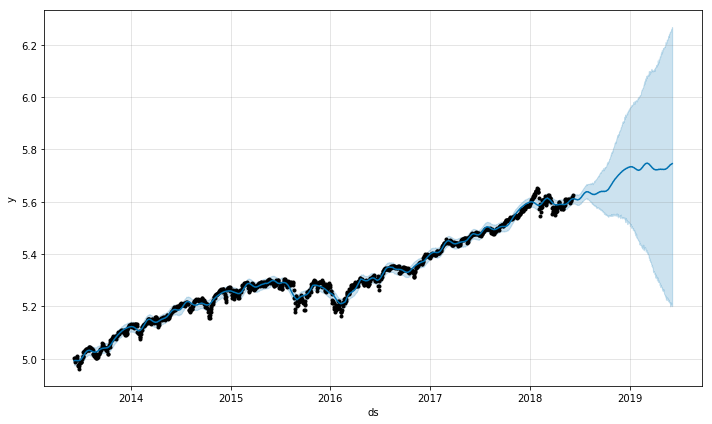

In [6]:
# So what does this output look like?
m.plot(forecast);

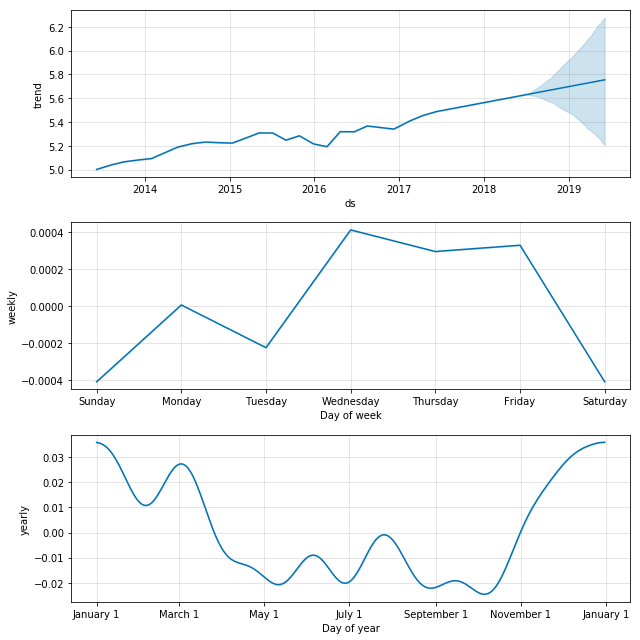

In [7]:
# One of the real strengths of Prophet its ability to look at seasonality. Take a look. 
# See anything interesting? (check out the weekly)
m.plot_components(forecast);

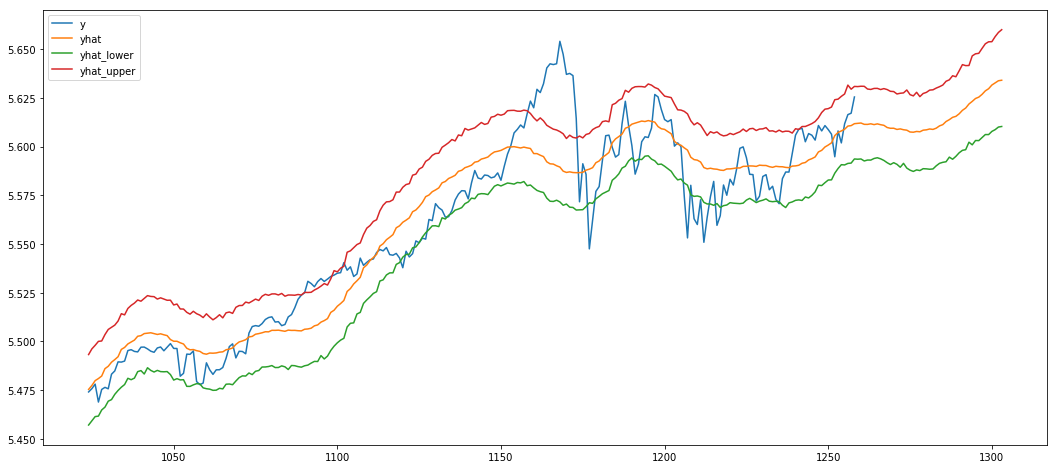

In [8]:
# Let's blow a particular section up a little to see what is really going on.
forecast['y'] = df['y']
forecast[['y','yhat', 'yhat_lower', 'yhat_upper']][-600:-320].plot(figsize=(18,8));

In [9]:
# always look at the raw data! 
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat,y
1619,2019-06-02,5.753093,5.215822,6.268480,5.208806,6.259818,-0.010069,-0.010069,-0.010069,0.0,0.0,0.0,-0.000410,-0.000410,-0.000410,-0.009658,-0.009658,-0.009658,5.743024,NaN
1620,2019-06-03,5.753461,5.212532,6.271036,5.204596,6.260195,-0.009342,-0.009342,-0.009342,0.0,0.0,0.0,0.000006,0.000006,0.000006,-0.009348,-0.009348,-0.009348,5.744119,NaN
1621,2019-06-04,5.753829,5.209243,6.273591,5.210801,6.260265,-0.009357,-0.009357,-0.009357,0.0,0.0,0.0,-0.000225,-0.000225,-0.000225,-0.009131,-0.009131,-0.009131,5.744472,NaN
1622,2019-06-05,5.754196,5.206614,6.276106,5.201576,6.268060,-0.008599,-0.008599,-0.008599,0.0,0.0,0.0,0.000413,0.000413,0.000413,-0.009013,-0.009013,-0.009013,5.745597,NaN
1623,2019-06-06,5.754564,5.204736,6.278434,5.201071,6.266387,-0.008698,-0.008698,-0.008698,0.0,0.0,0.0,0.000296,0.000296,0.000296,-0.008994,-0.008994,-0.008994,5.745866,NaN


In [10]:
# maybe we check out the r2 score.
from sklearn.metrics import r2_score
round(r2_score(forecast['y'][:1200], forecast['yhat'][:1200]),3)

0.991

### Conclusion: Great, but additive not definitive.

> Looks pretty powerful! While the *r2* would indicate an instant couple _BILLION_ dollars in trading, this is not the case, r2 on normalized prices is not the best indicator of trading profit. Where I DO think this modeling technique really comes into play is in conjunction with other techniques. Specifically it is a great way to add a robust seasonality factor into a prediction model. 

One problem I'll note though, this is pretty slow computationally!

Thanks for reading, hope you found this insightful!